# 1 Imports

In [1]:
from torch.utils.data import Dataset
from PIL import Image as PILImage
import numpy as np
import torch

from abc import ABC, abstractmethod
from dataclasses import dataclass
from os import PathLike
import os

# Constants

In [2]:
BASE_DIR = os.path.abspath("")
ROOT_DIR = os.path.dirname(BASE_DIR)
KZ_BASE_DIR = os.path.join(ROOT_DIR, "DJI_202507131523_004")

TRAIN_MODEL = False

print(ROOT_DIR)
print(BASE_DIR, KZ_BASE_DIR)

D:\AgriNet-Research\agrinet\datasets
D:\AgriNet-Research\agrinet\datasets\Agriculture-Vision-2021 D:\AgriNet-Research\agrinet\datasets\DJI_202507131523_004


In [3]:
dataset_name = "_dataset_mini"
kz_dataset_name = "_dataset"

dataset_path = os.path.join(BASE_DIR, dataset_name)
kz_dataset_path = os.path.join(KZ_BASE_DIR, kz_dataset_name)

dataset_train_path = os.path.join(dataset_path, "train")
dataset_val_path = os.path.join(dataset_path, "val")

dataset_test_path = os.path.join(dataset_path, "test")
kz_dataset_test_path = os.path.join(kz_dataset_path, "test")

# Train dataset paths
IMAGE_DIRS = [
    os.path.join(dataset_train_path, "images", "rgbn"),
    os.path.join(dataset_train_path, "aug_images", "rgbn"),
]

LABEL_DIRS = [
    os.path.join(dataset_train_path, "labels"),
    os.path.join(dataset_train_path, "aug_labels"),
]

# Validation dataset paths
# NOTE: Each label has a folder for each class (labels/class_x, etc.)
VAL_IMAGE_RGB_DIR = os.path.join(dataset_val_path, "images", "rgb")
VAL_IMAGE_NIR_DIR = os.path.join(dataset_val_path, "images", "nir")
VAL_LABEL_DIRS = [
    os.path.join(dataset_val_path, "labels"),
]

# Test dataset paths
INCLUDE_US_TEST_DATASET = True
INCLUDE_KZ_TEST_DATASET = False

TEST_IMAGE_RGB_DIRS = []
TEST_IMAGE_NIR_DIRS = []

if INCLUDE_US_TEST_DATASET:
    TEST_IMAGE_RGB_DIRS.append(os.path.join(dataset_test_path, "images", "rgb"))
    TEST_IMAGE_NIR_DIRS.append(os.path.join(dataset_test_path, "images", "nir"))

if INCLUDE_KZ_TEST_DATASET:
    TEST_IMAGE_RGB_DIRS.append(os.path.join(kz_dataset_test_path, "images", "rgb"))
    TEST_IMAGE_NIR_DIRS.append(os.path.join(kz_dataset_test_path, "images", "nir"))

print(dataset_path, kz_dataset_path)

D:\AgriNet-Research\agrinet\datasets\Agriculture-Vision-2021\_dataset_mini D:\AgriNet-Research\agrinet\datasets\DJI_202507131523_004\_dataset


# Image classes

In [4]:
class ImageSource(ABC):
    @abstractmethod
    def load(self) -> torch.Tensor:
        raise NotImplementedError

    @staticmethod
    def _load_image_from_numpy(arr: np.ndarray) -> torch.Tensor:
        return torch.from_numpy(arr).long()

    @classmethod
    def _load_image_from_path(cls, path: str | PathLike) -> torch.Tensor:
        arr = np.array(PILImage.open(path))
        return cls._load_image_from_numpy(arr)
    
    def __repr__(self) -> str:
        return self.__class__.__name__

class Image(ImageSource):
    pass

class Mask(ImageSource):
    pass
    
@dataclass
class ImageData:
    image_id: str
    image: Image
    mask: Mask

In [5]:
class RGBImagePlusNIR(Image):
    """ RGB Image with an additional Near-Infrared (NIR) channel."""

    def __init__(self, rgb_path: str, nir_path: str, normalize=True):
        self.rgb_path = rgb_path
        self.nir_path = nir_path
        self.normalize = normalize
        
    def load(self) -> torch.Tensor:
        rgb = self._load_image_from_path(self.rgb_path).float().permute(2, 0, 1)  # (3, H, W)
        nir = self._load_image_from_path(self.nir_path).float().unsqueeze(0)      # (1, H, W)
        img = torch.cat([rgb, nir], dim=0)  # (4, H, W)
        
        if self.normalize:
            img = img / 255.0  # Normalize to [0, 1]
        
        return img


class RGBNImage(Image):
    """Png image with 4 channels: Red, Green, Blue, Near-Infrared (NIR)."""

    def __init__(self, rgbn_path: str, normalize=True):
        if not self._is_png_image(rgbn_path):
            raise ValueError(f"RGBNImage only supports PNG images. Given file: {rgbn_path}")
        self.rgbn_path = rgbn_path
        self.normalize = normalize
        
    def load(self) -> torch.Tensor:
        img = self._load_image_from_path(self.rgbn_path).float().permute(2, 0, 1)
        if self.normalize:
            img = img / 255.0  # Normalize to [0, 1]
        return img
    
    @staticmethod
    def _is_png_image(file_path: str) -> bool:
        return file_path.lower().endswith('.png')

In [6]:
class OneHotMask(Mask):
    def __init__(self, *mask_paths: str):
        self._mask_paths = mask_paths
        self._labels_count = len(mask_paths)
        
    def load(self) -> torch.Tensor:
        tensors = []

        mask_paths = sorted(self._mask_paths)

        for mask_path in mask_paths:
            image = self._load_image_from_path(mask_path)
            mask = self._get_mask(image)
            tensors.append(mask)

        return torch.cat(tensors, dim=0)  # (C, H, W)
    
    @staticmethod
    def _get_mask(image: torch.Tensor) -> torch.Tensor:
        return image.unsqueeze(0)  # (1, H, W)
    
    def __str__(self) -> str:
        cls_name = self.__class__.__name__
        labels_count = self._labels_count
        return f"{cls_name}(labels={labels_count})"

class EmptyMask(Mask):
    def __init__(self, h: int, w: int, classes: int):
        self.h = h
        self.w = w
        self.classes = classes
    
    def load(self) -> torch.Tensor:
        return torch.zeros(self.classes, self.h, self.w, dtype=torch.long)


# ImageIdsParser

In [7]:
class ImageIdsParser:
    @classmethod
    def get_ids_for_dirs(cls, dirs: list[str]) -> list[str]:
        ids = []
        for d in dirs:
            ids.extend(cls.get_ids_for_dir(d))
        return ids
    
    @classmethod
    def get_ids_for_dir(cls, path: str) -> list[str]:
        ids_with_nones = [cls._get_id_from_image_path(p) for p in cls._get_items_by_path(path)]
        ids = [i for i in ids_with_nones if i]
        return ids
    
    @classmethod
    def _get_id_from_image_path(cls, path: str) -> str | None:
        try:
            return path.split(".")[0]  # id-with-coords.png
        except IndexError:
            return None
    
    @classmethod
    def _get_items_by_path(cls, path: str) -> list[str]:
        try:
            return os.listdir(path)
        except FileNotFoundError:
            print(f"[WARNING] Path not found: {path}")
            return []

In [8]:
IMAGE_IDS = ImageIdsParser.get_ids_for_dirs(IMAGE_DIRS)
print(f"Found {len(IMAGE_IDS)} image IDs.")

[WARNING] Path not found: D:\AgriNet-Research\agrinet\datasets\Agriculture-Vision-2021\_dataset_mini\train\aug_images\rgbn
Found 100 image IDs.


In [9]:
VAL_IMAGE_IDS = ImageIdsParser.get_ids_for_dirs([VAL_IMAGE_RGB_DIR])
print(f"Found {len(VAL_IMAGE_IDS)} validation image IDs.")

Found 99 validation image IDs.


In [10]:
TEST_IMAGE_IDS = ImageIdsParser.get_ids_for_dirs(TEST_IMAGE_RGB_DIRS)
print(f"Found {len(TEST_IMAGE_IDS)} test image IDs. Including KZ dataset: {INCLUDE_KZ_TEST_DATASET}")

Found 100 test image IDs. Including KZ dataset: False


# Dataset Abstraction

In [11]:
def image_data_to_tensor(data: ImageData) -> tuple[torch.Tensor, torch.Tensor]:
    img = data.image.load()
    mask = data.mask.load()
    return img, mask

class SegmentationDataset(ABC, Dataset):
    def __init__(self, image_ids: list[str]) -> None: 
        self._image_ids = image_ids

    def __len__(self) -> int:
        return len(self._image_ids)
        
    def __getitem__(self, idx: int):
        image_id = self._image_ids[idx]
        data = self.get_data(image_id)

        img, mask = image_data_to_tensor(data)
        
        # Validate shapes match
        if img.shape[-2:] != mask.shape[-2:]:
            raise ValueError(
                f"Shape mismatch for {image_id}: "
                f"image {img.shape} vs mask {mask.shape}"
            )
        
        return img, mask

    def first(self) -> ImageData | None:
        try:
            first_id = self._image_ids[0]
            return self.get_data(first_id)
        except IndexError:
            return None
    
    @abstractmethod
    def get_data(self, image_id: str) -> ImageData:
        raise NotImplementedError

# File Searcher

In [12]:
class FileSearcher:
    def __init__(self, search_paths: list[str]):
        self.search_paths = search_paths
        self._cache = self._build_index()
    
    def _build_index(self) -> dict[str, list[str]]:
        """Build filename -> paths mapping once"""
        index = {}
        for root_folder in self.search_paths:
            for dirpath, _, filenames in os.walk(root_folder):
                for filename in filenames:
                    key = filename.lower()
                    if key not in index:
                        index[key] = []
                    index[key].append(os.path.join(dirpath, filename))
        return index
    
    def search(self, file_name: str) -> list[str]:
        return self._cache.get(file_name.lower(), [])

# Datasets

In [13]:
class TrainDataset(SegmentationDataset):
    EXPECTED_MASKS_COUNT = 9
    
    _image_searcher = FileSearcher(IMAGE_DIRS)
    _mask_searcher = FileSearcher(LABEL_DIRS)
    
    def __init__(self, image_ids: list[str]) -> None: 
        super().__init__(image_ids=image_ids)
    
    def get_data(self, image_id: str) -> ImageData:
        return ImageData(
            image_id=image_id,
            image=self._get_image(image_id),
            mask=self._get_mask(image_id),
        )
    
    def _get_image(self, image_id: str) -> Image:
        file_name = self._get_file_name(image_id)
        rgbn_paths = self._image_searcher.search(file_name)

        if len(rgbn_paths) == 0 or len(rgbn_paths) > 1:
            raise Exception(f"Expected exactly one RGBN image for ID '{image_id}', found {len(rgbn_paths)}.")

        return RGBNImage(rgbn_paths[0])

    def _get_mask(self, image_id: str) -> Mask:
        file_name = self._get_file_name(image_id)
        masks = self._mask_searcher.search(file_name)

        if not masks:
            raise Exception(f"No masks found for image ID '{image_id}'.")

        self._validate_masks(masks)

        return OneHotMask(*masks)

    @classmethod
    def _validate_masks(cls, masks: list[str]) -> None:
        found = len(masks)
        expected = cls.EXPECTED_MASKS_COUNT

        if found != expected:
            raise Exception("Failed parse masks, {expected=}, {found=}")
    
    @staticmethod
    def _get_file_name(image_id: str) -> str:
        return f"{image_id}.png"


def _test() -> None:
    train_dataset = TrainDataset(image_ids=IMAGE_IDS)
    image_data = train_dataset.first()

    print(f"Loaded {len(train_dataset)} instances")
    
    if image_data:
        print(image_data)

_test()

Loaded 100 instances
ImageData(image_id='11IE4DKTR_11556-9586-12068-10098', image=RGBNImage, mask=OneHotMask)


In [14]:
class ValidationDataset(SegmentationDataset):
    EXPECTED_MASKS_COUNT = 9

    _rgb_searcher = FileSearcher([VAL_IMAGE_RGB_DIR])
    _nir_searcher = FileSearcher([VAL_IMAGE_NIR_DIR])
    _mask_searcher = FileSearcher(VAL_LABEL_DIRS)

    def __init__(self, image_ids: list[str]) -> None:
        super().__init__(image_ids=image_ids)

    def get_data(self, image_id: str) -> ImageData:
        return ImageData(
            image_id=image_id,
            image=self._get_image(image_id),
            mask=self._get_mask(image_id),
        )

    def _get_image(self, image_id: str) -> Image:
        file_name = self._get_file_name(image_id)

        rgb_paths = self._rgb_searcher.search(file_name)
        nir_paths = self._nir_searcher.search(file_name)

        if len(rgb_paths) != 1 or len(nir_paths) != 1:
            raise Exception(
                f"Expected exactly one RGB and one NIR image for ID '{image_id}', "
                f"found rgb={len(rgb_paths)}, nir={len(nir_paths)}."
            )

        return RGBImagePlusNIR(rgb_path=rgb_paths[0], nir_path=nir_paths[0])

    def _get_mask(self, image_id: str) -> Mask:
        file_name = self._get_mask_file_name(image_id)
        masks = self._mask_searcher.search(file_name)

        if not masks:
            raise Exception(f"No masks found for image ID '{image_id}' in validation set.")

        self._validate_masks(masks)

        return OneHotMask(*masks)

    @classmethod
    def _validate_masks(cls, masks: list[str]) -> None:
        found = len(masks)
        expected = cls.EXPECTED_MASKS_COUNT

        if found != expected:
            raise Exception(f"Failed parse masks, expected={expected}, found={found}")

    @staticmethod
    def _get_file_name(image_id: str) -> str:
        return f"{image_id}.jpg"
    
    @staticmethod
    def _get_mask_file_name(image_id: str) -> str:
        return f"{image_id}.png"

def _test() -> None:
    val_dataset = ValidationDataset(image_ids=VAL_IMAGE_IDS)
    image_data = val_dataset.first()

    print(f"Loaded {len(val_dataset)} instances in validation dataset")

    if image_data:
        print(image_data)

_test()

Loaded 99 instances in validation dataset
ImageData(image_id='138GZZR3U_2368-12251-2880-12763', image=RGBImagePlusNIR, mask=OneHotMask)


In [15]:
class TestDataset(SegmentationDataset):
    _rgb_searcher = FileSearcher(TEST_IMAGE_RGB_DIRS)
    _nir_searcher = FileSearcher(TEST_IMAGE_NIR_DIRS)

    def __init__(self, image_ids: list[str]) -> None:
        super().__init__(image_ids=image_ids)

    def get_data(self, image_id: str) -> ImageData:
        image = self._get_image(image_id)

        # Load once to get spatial size for dummy mask
        _, h, w = image.load().shape
        mask = EmptyMask(h=h, w=w, classes=9)

        return ImageData(image_id=image_id, image=image, mask=mask)

    def _get_image(self, image_id: str) -> Image:
        file_name_png = f"{image_id}.png"
        file_name_jpg = f"{image_id}.jpg"

        rgb_paths = self._rgb_searcher.search(file_name_jpg) + self._rgb_searcher.search(file_name_png)
        nir_paths = self._nir_searcher.search(file_name_jpg) + self._nir_searcher.search(file_name_png)

        if len(rgb_paths) == 1 and len(nir_paths) == 1:
            return RGBImagePlusNIR(rgb_path=rgb_paths[0], nir_path=nir_paths[0])
        
        raise Exception(f"Failed to resolve test image for ID '{image_id}': rgb={len(rgb_paths)}, nir={len(nir_paths)}")

def _test() -> None:
    test_dataset = TestDataset(image_ids=TEST_IMAGE_IDS)
    image_data = test_dataset.first()

    print(f"Loaded {len(test_dataset)} instances in test dataset")

    if image_data:
        print(image_data)

_test()

Loaded 100 instances in test dataset
ImageData(image_id='17FCUVCMI_1728-7254-2240-7766', image=RGBImagePlusNIR, mask=EmptyMask)


# Build model with SegmentationModels.Pytorch

In [16]:
from segmentation_models_pytorch.metrics import iou_score, get_stats
import segmentation_models_pytorch as smp

In [17]:
RGBN_CHANNELS = 4
CLASSES_COUNT = 9

def get_model():
    return smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=RGBN_CHANNELS,
    classes=CLASSES_COUNT,
    decoder_attention_type="scse",
)

model = get_model()

# Create DataLoader

In [18]:
def get_device_type() -> str:
    return "cuda" if torch.cuda.is_available() else "cpu"

In [19]:
from torch.utils.data import DataLoader
import os

train_dataset = TrainDataset(image_ids=IMAGE_IDS)
val_dataset = ValidationDataset(image_ids=VAL_IMAGE_IDS)
test_dataset = TestDataset(image_ids=TEST_IMAGE_IDS)

NUM_WORKERS = 0
BATCH_SIZE = 1

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True if get_device_type() == 'cuda' else False,  # Faster CPU->GPU transfer
    persistent_workers=True if NUM_WORKERS > 0 else False,  # Keep workers alive
    prefetch_factor=2 if NUM_WORKERS > 0 else None,  # Prefetch batches
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True if get_device_type() == 'cuda' else False,  # Faster CPU->GPU transfer
    persistent_workers=True if NUM_WORKERS > 0 else False,  # Keep workers alive
    prefetch_factor=2 if NUM_WORKERS > 0 else None,  # Prefetch batches
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True if get_device_type() == 'cuda' else False,  # Faster CPU->GPU transfer
    persistent_workers=True if NUM_WORKERS > 0 else False,  # Keep workers alive
    prefetch_factor=2 if NUM_WORKERS > 0 else None,  # Prefetch batches
)

# Train Model

In [20]:
def calculate_loss(pred: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
    # Using multilabel Dice loss since targets are one-hot encoded per class (B, C, H, W)
    return dice_loss(pred, target)

dice_loss = smp.losses.DiceLoss(mode='multilabel')

In [21]:
def calculate_metrics(outputs: torch.Tensor, masks: torch.Tensor, num_classes=9):
    preds = torch.argmax(outputs, dim=1)
    
    if masks.dim() == 4:
        target_idx = torch.argmax(masks, dim=1)
    else:
        target_idx = masks
    
    tp, fp, fn, tn = get_stats(
        preds.long(), 
        target_idx.long(), 
        mode='multiclass', 
        num_classes=num_classes
    )
    
    # Use built-in functions
    from segmentation_models_pytorch.metrics import f1_score
    iou = iou_score(tp, fp, fn, tn, reduction='micro')
    dice = f1_score(tp, fp, fn, tn, reduction='micro')  # F1 = Dice
    
    return dice.item(), iou.item()

In [22]:
def train_one_epoch(
    model: torch.nn.Module,
    loader: DataLoader,
    optimizer: torch.optim.Optimizer,
    scaler=None
) -> float:
    model.train()
    total_loss = 0
    
    for imgs, masks in loader:
        # imgs: (B, 4, H, W), masks: (B, C, H, W) one-hot
        imgs, masks = imgs.to(device), masks.to(device)
        optimizer.zero_grad()
        
        if scaler:
            with autocast(device_type):
                outputs = model(imgs)
                loss = calculate_loss(outputs, masks)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            outputs = model(imgs)
            loss = calculate_loss(outputs, masks)
            loss.backward()
            optimizer.step()
        
        total_loss += loss.item() * imgs.size(0)
    
    return total_loss / len(loader.dataset)


def validate_one_epoch(model: torch.nn.Module, loader: DataLoader, num_classes=9) -> tuple[float, float, float]:
    """Validate the model for one epoch. Returns loss, dice, iou."""
    model.eval()

    total_loss = 0
    total_dice = 0
    total_iou = 0
    
    with torch.no_grad():
        for imgs, masks in loader:
            imgs, masks = imgs.to(device), masks.to(device)
            outputs = model(imgs)
            loss = calculate_loss(outputs, masks)
            
            total_loss += loss.item() * imgs.size(0)
            
            dice, iou = calculate_metrics(outputs, masks, num_classes=num_classes)
            total_dice += dice * imgs.size(0)
            total_iou += iou * imgs.size(0)
    
    dataset_size = len(loader.dataset)
    return (total_loss / dataset_size,
            total_dice / dataset_size,
            total_iou / dataset_size)

In [23]:
from torch.amp import GradScaler, autocast
from torch import nn
import torch

device_type = get_device_type()
device = torch.device(device_type)
print(f"Using device: {device_type}")

Using device: cpu


In [24]:
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-5

model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scaler = GradScaler(device_type) if device_type == 'cuda' else None

In [25]:
EPOCHS = 10 if get_device_type() == 'cuda' else 1
MODEL_NAME = "best_model.pth"

def train_model() -> None:
    best_val_iou = 0.0
    patience = 5
    patience_counter = 0

    for epoch in range(EPOCHS):
        train_loss = train_one_epoch(model, train_loader, optimizer, scaler)
        val_loss, val_dice, val_iou = validate_one_epoch(model, val_loader, num_classes=9)
        
        print(f"Epoch [{epoch+1}/{EPOCHS}] "
              f"| Train Loss: {train_loss:.4f} "
              f"| Val Loss: {val_loss:.4f} "
              f"| Dice: {val_dice:.4f} "
              f"| IoU: {val_iou:.4f}")
        
        # Save best model only
        if val_iou > best_val_iou:
            best_val_iou = val_iou
            patience_counter = 0
            checkpoint = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_iou': val_iou,
            }
            torch.save(checkpoint, MODEL_NAME)
            print(f"✓ Saved new best model (IoU: {val_iou:.4f})")
        else:
            patience_counter += 1
        
        # Early stopping
        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break

if TRAIN_MODEL:
    train_model()

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = get_model()
model.to(device)

# Robust checkpoint loading: supports raw state_dict or full checkpoint
ckpt = torch.load(MODEL_NAME, map_location=device, weights_only=True)

if isinstance(ckpt, dict) and "model_state_dict" in ckpt:
    state_dict = ckpt["model_state_dict"]
else:
    # Assume it's a plain state_dict
    state_dict = ckpt

# Strip potential 'module.' prefixes (if saved from DataParallel)
from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    new_key = k.replace("module.", "")
    new_state_dict[new_key] = v

missing, unexpected = model.load_state_dict(new_state_dict, strict=False)
if missing:
    print(f"Warning: missing keys when loading: {missing}")
if unexpected:
    print(f"Warning: unexpected keys when loading: {unexpected}")

model.eval()
print("Model loaded and set to eval mode on", device)


Model loaded and set to eval mode on cpu


In [27]:
# Get a batch from the validation DataLoader
imgs, gt_masks = next(iter(test_loader))  # imgs: (B, 4, H, W), gt_masks: (B, C, H, W)
imgs = imgs.to(device)

# Run the loaded model to get predicted logits
with torch.no_grad():
    logits = model(imgs)  # (B, 9, H, W)
    probs = torch.softmax(logits, dim=1)  # (B, 9, H, W)
    pred_masks_idx = torch.argmax(probs, dim=1)  # (B, H, W)

# Select the first image/mask from the batch
img0 = imgs[0]  # (4, H, W)
gt0 = gt_masks[0]  # (9, H, W) one-hot
pred0_idx = pred_masks_idx[0]  # (H, W)

print(f"img0 shape: {img0.shape}")
print(f"gt0 (one-hot) shape: {gt0.shape}")
print(f"pred0 class-index mask shape: {pred0_idx.shape}")

img0 shape: torch.Size([4, 512, 512])
gt0 (one-hot) shape: torch.Size([9, 512, 512])
pred0 class-index mask shape: torch.Size([512, 512])


In [28]:
palette = [
    (255, 0, 0),      # class 0 - red
    (0, 255, 0),      # class 1 - green
    (0, 0, 255),      # class 2 - blue
    (255, 255, 0),    # class 3 - yellow
    (255, 0, 255),    # class 4 - magenta
    (0, 255, 255),    # class 5 - cyan
    (255, 165, 0),    # class 6 - orange
    (128, 0, 128),    # class 7 - purple
    (128, 128, 128),  # class 8 - gray
]

In [29]:
def predict_mask(image: ImageData) -> torch.Tensor:
    img, _ = image_data_to_tensor(image)
    img_batch = img.unsqueeze(0).to(device)  # (1, 4, H, W)

    with torch.no_grad():
        logits = model(img_batch)          # (1, 9, H, W)
        probs = torch.softmax(logits, dim=1)  # (1, 9, H, W)
        pred_idx = torch.argmax(probs, dim=1) # (1, H, W)

    return pred_idx[0]  # (H, W)

def display_mask(image: torch.Tensor, palette: list[tuple[int, int, int]]):
    h, w = image.shape[0], image.shape[1]

    color_img = np.zeros((h, w, 3), dtype=np.uint8)
    mask_np = image.cpu().numpy()

    for c, color in enumerate(palette):
        color_img[mask_np == c] = color

    display(PILImage.fromarray(color_img))

Predicted class-index mask shape: torch.Size([512, 512])


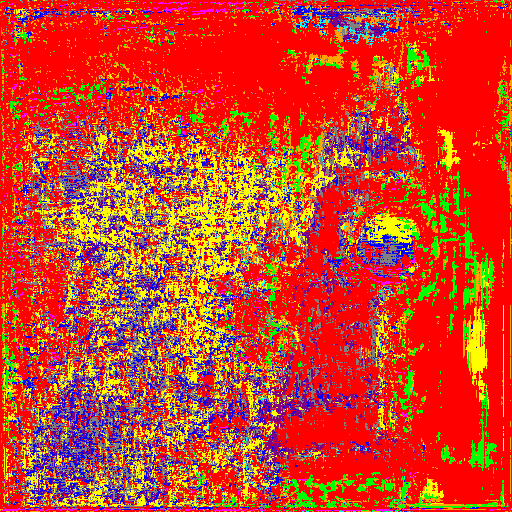

In [30]:
test_image_data = test_dataset.first()

pred_idx_mask = predict_mask(test_image_data)
print(f"Predicted class-index mask shape: {pred_idx_mask.shape}")

display_mask(pred_idx_mask, palette=palette)